This program follows the below mentioned blog.

https://www.analyticsvidhya.com/blog/2018/09/deep-learning-video-classification-python/

# Loading Libraries

In [1]:
import cv2 #capture videos
import math #mathematical operations
import matplotlib.pyplot as plt #visualizations
%matplotlib inline
import pandas as pd
from keras.preprocessing import image #image preprocessing
import numpy #mathematical operations
from keras.utils import np_utils
from skimage.transform import resize #image resize
import numpy as np

Using TensorFlow backend.


# Step1: Read Video, extract images and save them

In [ ]:
count=0
videoFile='../data/Tom and jerry.mp4'
cap=cv2.VideoCapture(videoFile) #capture video from given video path
frameRate=cap.get(5) 
x=1
while(cap.isOpened()):
    frameId=cap.get(1) #current frame number
    ret,frame=cap.read()
    if ret!=True:
        break
    if (frameId%math.floor(frameRate)==0):
        filename='frame%d.jpg'%count
        count+=1
        cv2.imwrite('../data/'+filename,frame)
cap.release()
print('Done')

We have extracted one frame for each second, from the entire duration of the video. Since the duration of the video is 4:58 minutes (298 seconds), we now have 298 images in total.

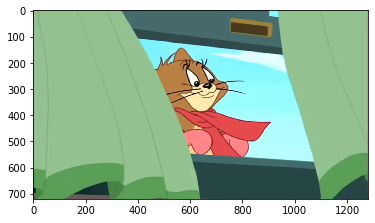

In [2]:
#reading and vizualizing one image
img=plt.imread('../data/frame0.jpg')
plt.imshow(img);

## Objective: Our task is to identify which image has TOM, and which image has JERRY.

We have cartoon images so it’ll be very difficult (if not impossible) for any pre-trained model to identify TOM and JERRY in a given video

# Step – 2: Label a few images for training the model

Blog's writer have already tagged few of the images and saved the information in mappings.csv file which we will use here.

Otherwise someone has to tag few images manually to train the model.

Classes has been classified as below.

0 – neither JERRY nor TOM

1 – for JERRY

2 – for TOM

In [3]:
data=pd.read_csv('../data/mapping.csv')
data.head()

Image_ID  Class
0  frame0.jpg      1
1  frame1.jpg      1
2  frame2.jpg      2
3  frame3.jpg      2
4  frame4.jpg      2

In [4]:
X=[] #empty list
for img_name in data.Image_ID:
    img=plt.imread('../data/'+img_name)
    X.append(img)
X=np.array(X) #list to array 

Tada! We now have the images with us. Remember, we need two things to train our model:

- Training images, and
- Their corresponding class

Since there are three classes, we will one hot encode them using the to_categorical() function of keras.utils.

In [5]:
y=data.Class
dummy_y=np_utils.to_categorical(y)

We will be using a VGG16 pretrained model which takes an input image of shape (224 X 224 X 3). Since our images are in a different size, we need to reshape all of them. We will use the resize() function of skimage.transform to do this.

In [6]:
images=[]
for i in range(0,X.shape[0]):
    a=resize(X[i],preserve_range=True,output_shape=(224,224)).astype(int)
    images.append(a)
X=np.array(images)

In [7]:
X.shape

(298, 224, 224, 3)

All the images have been reshaped to 224 X 224 X 3. But before passing any input to the model, we must preprocess it as per the model’s requirement. Otherwise, the model will not perform well enough. Use the preprocess_input() function of keras.applications.vgg16 to perform this step.

In [8]:
from keras.applications.vgg16 import preprocess_input
X=preprocess_input(X,mode='tf')

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid=train_test_split(X,dummy_y,test_size=0.3,random_state=42)

# Step3: Building the model

In [10]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense,InputLayer,Dropout

We will now load the VGG16 pretrained model and store it as base_model:

In [11]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3)) #include_top=False to remove the top layer

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



We will make predictions using this model for X_train and X_valid, get the features, and then use those features to retrain the model.

In [12]:
X_train=base_model.predict(X_train)
X_valid=base_model.predict(X_valid)
X_train.shape,X_valid.shape

((208, 7, 7, 512), (90, 7, 7, 512))

The shape of X_train and X_valid is (208, 7, 7, 512), (90, 7, 7, 512) respectively. In order to pass it to our neural network, we have to reshape it to 1-D.

In [13]:
X_train=X_train.reshape(208,7*7*512)
X_valid=X_valid.reshape(90,7*7*512)

We will now preprocess the images and make them zero-centered which helps the model to converge faster.

In [14]:
train=X_train/X_train.max()
X_valid=X_valid/X_train.max()

Finally, we will build our model. This step can be divided into 3 sub-steps:

1. Building the model
2. Compiling the model
3. Training the model

In [15]:
#Building the model
model=Sequential()
model.add(InputLayer((7*7*512,))) #input layer
model.add(Dense(units=1024,activation='sigmoid')) #hidden layer
model.add(Dense(3,activation='softmax')) #output layer

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 25,694,211
Trainable params: 25,694,211
Non-trainable params: 0
_________________________________________________________________


We have a hidden layer with 1,024 neurons and an output layer with 3 neurons (since we have 3 classes to predict). Now we will compile our model:

In [16]:
#Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In the final step, we will fit the model and simultaneously also check its performance on the unseen images, i.e., validation images:

In [17]:
#Training the model
model.fit(train,y_train,epochs=100,validation_data=(X_valid,y_valid))

Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 4s 21ms/step - loss: 1.2487 - accuracy: 0.5385 - val_loss: 0.6283 - val_accuracy: 0.7444
Epoch 2/100
208/208 [==============================] - 4s 17ms/step - loss: 0.4859 - accuracy: 0.7885 - val_loss: 0.5970 - val_accuracy: 0.7667
Epoch 3/100
208/208 [==============================] - 4s 19ms/step - loss: 0.2352 - accuracy: 0.9327 - val_loss: 0.4087 - val_accuracy: 0.8444
Epoch 4/100
208/208 [==============================] - 4s 18ms/step - loss: 0.1441 - accuracy: 0.9712 - val_loss: 0.3861 - val_accuracy: 0.8333
Epoch 5/100
208/208 [==============================] - 4s 17ms/step - loss: 0.0741 - accuracy: 0.9808 - val_loss: 0.3711 - val_accuracy: 0.8333
Epoch 6/100
208/208 [==============================] - 4s 17ms/step - loss: 0.0536 - accuracy: 0.9952 - val_loss: 0.3417 - val_accuracy: 0.8444
Epoch 7/100
208/208 [==============================] - 4s 17ms/step - loss: 0.0407 - accura

208/208 [==============================] - 4s 17ms/step - loss: 0.0076 - accuracy: 0.9952 - val_loss: 0.4608 - val_accuracy: 0.8333
Epoch 58/100
208/208 [==============================] - 4s 17ms/step - loss: 0.0179 - accuracy: 0.9952 - val_loss: 0.3836 - val_accuracy: 0.8556
Epoch 59/100
208/208 [==============================] - 4s 17ms/step - loss: 0.0103 - accuracy: 0.9952 - val_loss: 0.3254 - val_accuracy: 0.8667
Epoch 60/100
208/208 [==============================] - 4s 17ms/step - loss: 0.0095 - accuracy: 0.9952 - val_loss: 0.3749 - val_accuracy: 0.8444
Epoch 61/100
208/208 [==============================] - 4s 17ms/step - loss: 0.0088 - accuracy: 0.9952 - val_loss: 0.3539 - val_accuracy: 0.8667
Epoch 62/100
208/208 [==============================] - 4s 17ms/step - loss: 0.0093 - accuracy: 0.9904 - val_loss: 0.3409 - val_accuracy: 0.8667
Epoch 63/100
208/208 [==============================] - 4s 17ms/step - loss: 0.0101 - accuracy: 0.9952 - val_loss: 0.3516 - val_accuracy: 0.866

We can see it is performing really well on the training as well as the validation images. <b>We got an accuracy of around 85% on unseen images.</b> And this is how we train a model on video data to get predictions for each frame.

In the next section, we will try to calculate the screen time of TOM and JERRY in a new video.

# Calculating the screen time

In [40]:
count=0
videoFile='../data/Tom and Jerry 3.mp4'
cap=cv2.VideoCapture(videoFile)
frameRate=cap.get(5)
x=1
while(cap.isOpened()):
    frameId=cap.get(1)
    ret,frame=cap.read()
    if ret!=True:
        break
    if (frameId%math.floor(frameRate)==0):
        filename='../data/'+'test%d.jpg'%count
        count+=1
        cv2.imwrite(filename,frame)
cap.release()
print('Done')

Done


After extracting the frames from the new video, we will now load the test.csv file which contains the names of each extracted frame.

In [18]:
test=pd.read_csv('../data/test.csv')

Next, we will import the images for testing and then reshape them as per the requirements of the aforementioned pretrained model:

In [19]:
test_image=[]
for img_name in test.Image_ID:
    img=plt.imread('../data/'+img_name)
    test_image.append(img)
test_image=np.array(test_image)

In [20]:
images=[]
for i in range(0,test_image.shape[0]):
    a=resize(test_image[i],preserve_range=True,output_shape=(224,224)).astype(int)
    images.append(a)
test_image=np.array(images)

We need to make changes to these images similar to the ones we did for the training images. We will preprocess the images, use the base_model.predict() function to extract features from these images using the VGG16 pretrained model, reshape these images to 1-D form, and make them zero-centered:

In [21]:
#preprocess the images
test_image=preprocess_input(test_image,mode='tf')

#extracting features from the images using pretrained model
test_image=base_model.predict(test_image)

#converting the images to 1-D form
test_image=test_image.reshape(186,7*7*512)

#zero centered images
test_image=test_image/test_image.max()


Since we have trained the model previously, we will make use of that model to make prediction for these images.

# Step 4: make predictions for test_images

In [22]:
predictions=model.predict_classes(test_image)

# Step – 5 Calculate the screen time of both TOM and JERRY

In [23]:
print("The screen time of JERRY is", predictions[predictions==1].shape[0], "seconds")
print("The screen time of TOM is", predictions[predictions==2].shape[0], "seconds")

The screen time of JERRY is 6 seconds
The screen time of TOM is 116 seconds
